In [1]:
import data_providers as data_providers
train_data = data_providers.SentimentDataProvider('train',batch_size = 100)

In [2]:
datainputs = train_data.inputs
datatargets = train_data.targets
print(datainputs.shape)
print(datatargets.shape)

(50000, 200)
(50000, 2)


In [3]:
import numpy as np
m = 'D:\\Edinburgh\\MLP\\moviereview\\oovec.txt' 
emm = np.loadtxt(m)


In [4]:
emm

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.65687251e+00, -2.13421679e+00, -1.14120746e+00, ...,
        -3.89805943e-01, -1.38813094e-03, -8.80363226e-01],
       [ 1.33517051e+00, -1.46170712e+00, -8.79757106e-01, ...,
        -8.08012128e-01, -2.68112159e+00,  2.02673030e+00],
       ...,
       [ 2.50109099e-03,  9.85768810e-03, -2.24172766e-03, ...,
         3.60512431e-03, -4.97169280e-03, -1.99030992e-03],
       [ 3.36064324e-02,  4.04373510e-03,  2.27453262e-02, ...,
         7.73886102e-04,  1.89416725e-02,  6.78377366e-03],
       [-3.02166976e-02,  4.89643449e-03,  1.11722723e-02, ...,
         1.26498742e-02,  1.30310515e-02, -1.21284444e-02]])

In [5]:
print(emm.shape)

(41146, 100)


In [6]:
import time

In [ ]:
import tensorflow as tf
import sys
from tensorflow.contrib import rnn
sys.path.append("..")
tf.reset_default_graph() 
# Network Parameters
num_input = 100 # data input dimension
timesteps = 200 # timesteps
num_hidden = 100 # hidden layer num of features
num_classes = 2 
layer_num = 2
batch_size = 100
# tf Graph input
with tf.name_scope('data'):
    X = tf.placeholder(tf.int32, [batch_size, timesteps],'inputs')
    Y = tf.placeholder(tf.float32, [batch_size, num_classes],'targets')
    print(X.shape)
    print(Y.shape)
    #embedding
    embedding = tf.placeholder(tf.float32,[41146,100])
    inputs = tf.nn.embedding_lookup(embedding,X)
    keep_prob = tf.placeholder(tf.float32)

#lstm _ dropout
lstm_cell = tf.nn.rnn_cell.LSTMCell(num_hidden,state_is_tuple=True)
lstm_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell]*3,  state_is_tuple=True)  
lstm_cell = rnn.DropoutWrapper(cell=lstm_cell, input_keep_prob=0.8, output_keep_prob=0.8)
lstm_cell_bw = tf.nn.rnn_cell.LSTMCell(num_hidden,state_is_tuple=True)
lstm_cell_bw = tf.nn.rnn_cell.MultiRNNCell([lstm_cell_bw]*3,  state_is_tuple=True)
lstm_cell_bw = rnn.DropoutWrapper(cell=lstm_cell, input_keep_prob=0.8, output_keep_prob=0.8)
#out_put, state = tf.nn.dynamic_rnn(lstm_cell, inputs , dtype=tf.float32)
(out_put, out_put_bw), state = tf.nn.bidirectional_dynamic_rnn(lstm_cell, lstm_cell_bw, inputs,  dtype=tf.float32)

outputs = tf.concat((out_put, out_put_bw), 2)
u_context = tf.Variable(tf.truncated_normal([num_hidden * 2]), name='u_context')
h = tf.layers.dense(outputs, num_hidden * 2, activation=tf.nn.tanh)
alpha = tf.nn.softmax(tf.reduce_sum(tf.multiply(h, u_context), axis=2, keep_dims=True), dim=1)
last = tf.reduce_sum(tf.multiply(outputs, alpha), axis=1)
scale = tf.Variable(tf.ones([200]))
offset = tf.Variable(tf.zeros([200]))
variance_epsilon = 0.001
wb_mean, wb_var = tf.nn.moments(last,[0,1])
last= tf.nn.batch_normalization(last, wb_mean, wb_var,offset, scale, variance_epsilon)

#out_put = tf.transpose(out_put, [1, 0, 2])
#last = tf.gather(out_put , int(out_put .get_shape()[0]) - 1)

#out_put_bw = tf.transpose(out_put_bw, [1, 0, 2])
#last_bw = tf.gather(out_put_bw , int(out_put_bw .get_shape()[0]) - 1)

#W = tf.Variable(tf.zeros([num_hidden, num_classes]))
#W = tf.Variable(tf.zeros([2 * num_hidden, num_hidden]))
#bias = tf.Variable(tf.zeros([num_hidden]))
lr = 1e-4
#last = tf.concat([last,last_bw],1)
dense_pre_last = tf.layers.dense(last, 2*num_hidden, activation = tf.nn.selu)
y_pre = tf.layers.dense(dense_pre_last, 2, activation = tf.nn.softmax)

cost = - tf.reduce_mean(Y * tf.log(tf.clip_by_value(y_pre,1e-10,1.0)))
train_op = tf.train.AdamOptimizer(lr).minimize(cost)
correct_prediction  = tf.equal(tf.argmax(y_pre,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#tensorboard
#tf.summary.scalar('acc',accuracy)
#tf.summary.scalar('loss',cost)

(100, 200)
(100, 2)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead


In [ ]:
import numpy as np
c = emm # word embedding accay, read from the pre-data
acclist = []
errorlist =  []
acclist1 = []
errorlist1 =  []
sess = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
sess.run(init_op)
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter("logs/", sess.graph)
sess.run(init_op)
batch_size = 100
#no_of_batches = int(len(datainputs)/batch_size)
epoch = 50
for i in range(epoch):
    ptr = 0
    runacc = 0
    runerror = 0
    m = 0
    n = 0
    start_time = time.time()
    for j in range(400):
        inp, out = datainputs[ptr:ptr+batch_size], datatargets[ptr:ptr+batch_size]
#         print(inp.shape)
        ptr+=batch_size
        _, error, correct = sess.run( [train_op , cost, accuracy],feed_dict = { X: inp, Y: out, keep_prob: 1.0, embedding: c})
        runacc += correct
        runerror += error
    #result = sess.run(merged, feed_dict = { X: inp, Y: out, keep_prob: 1.0, embedding: c}
    #writer.add_summary(result,i)
    m = runacc / 400
    n = runerror / 400
    acclist.append(m)
    errorlist.append(n)
    print ("step %d, training accuracy %g, training error %g" %  ( (i+1), m, n))
    ptr1 = 45000
    runacc1 = 0
    runerror1 = 0
    m1 = 0
    n1 = 0
    for k in range(50):
        inp, out = datainputs[ptr1:ptr1+batch_size], datatargets[ptr1:ptr1+batch_size]
        ptr1+=batch_size
        error1, correct1 = sess.run( [cost, accuracy],feed_dict = { X: inp, Y: out, keep_prob: 1.0, embedding: c})
        runacc1 += correct1
        runerror1 += error1
    m1 = runacc1 / 50
    n1 = runerror1 / 50
    print ("step %d, val accuracy %g, val error %g" %  ( (i+1), m1, n1))
    acclist1.append(m1)
    errorlist1.append(n1)
    end_time = time.time()
    htime = end_time - start_time
    print("step %d, time %g," %  ( (i+1), htime))
sess.close()



step 1, training accuracy 0.89105, training error 0.104049
step 1, val accuracy 0.9132, val error 0.0830295
step 1, time 1701.18,
step 2, training accuracy 0.9121, training error 0.0843359
step 2, val accuracy 0.9208, val error 0.0754082
step 2, time 1854.28,
step 3, training accuracy 0.922225, training error 0.0780761
step 3, val accuracy 0.9302, val error 0.0706321
step 3, time 1857.99,
step 4, training accuracy 0.92745, training error 0.0742628
step 4, val accuracy 0.9296, val error 0.0700153
step 4, time 1765.4,
step 5, training accuracy 0.931375, training error 0.0707145
step 5, val accuracy 0.934, val error 0.06897
step 5, time 1685.21,
step 6, training accuracy 0.9333, training error 0.0687237


In [ ]:
acc = np.array(acclist, dtype = 'float32')
acc1 = np.array(acclist1, dtype = 'float32')
error = np.array(errorlist, dtype = 'float32')
error1 = np.array(errorlist1, dtype = 'float32')

In [184]:
macc = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_attention_batch_acc.txt'
macc1 = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_attention_batch_acc1.txt' 
merror = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_attention_batch_error.txt' 
merror1 = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_attention_batch_error1.txt' 
np.savetxt(macc,acc)
np.savetxt(macc1,acc1)
np.savetxt(merror,error)
np.savetxt(merror1,error1)

# macc = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_nodrop_base_acc.txt'
# macc = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.9_base_acc.txt'
# macc = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_base_acc.txt'
# macc = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.6_base_acc.txt'
# macc = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidi_acc.txt'
# macc = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_acc1.txt'
# macc = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_2layers_acc1.txt'
# macc = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_3layer_acc1.txt'
# macc = 'D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_attention_acc1.txt'

In [246]:
acc = np.loadtxt('D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_attention_batch_acc.txt')
acc1 = np.loadtxt('D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_attention_batch_acc1.txt')
acc2 = np.loadtxt('D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.8_bidiselu_acc1.txt')
acc3 = np.loadtxt('D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_drop0.9_base_error1.txt')
error = np.loadtxt('D:\\Edinburgh\\MLP\\moviereview\\train_data\\train_data/40000c_200s_100d_nodrop_base_error.txt')
error1 = np.loadtxt('D:\\Edinburgh\\MLP\\moviereview\\train_data\\40000c_200s_100d_nodrop_base_error1.txt')


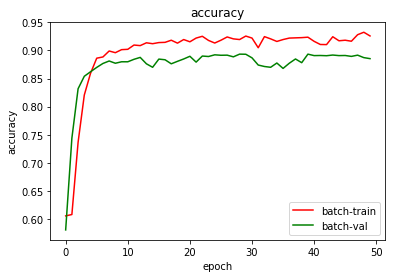

In [247]:
acc = np.array(acc, dtype = 'float32')
acc1 = np.array(acc1, dtype = 'float32')
acc2 = np.array(acc2, dtype = 'float32')
acc3 = np.array(acc3, dtype = 'float32')
trainerror = np.array(error, dtype = 'float32')
valerror = np.array(error1, dtype = 'float32')
import matplotlib.pyplot as plt 
x1=range(0,50) 
x2=range(0,50)
x3=range(0,50) 
x4=range(0,50)
plt.plot(x1,acc,label='batch-train',color='r') 
plt.plot(x2,acc1,label='batch-val',color = 'g') 
#plt.plot(x3,acc2,label='bi-dir-selu',color='y') 
#plt.plot(x4,acc3,label='0.6-drop') 
plt.xlabel('epoch') 
plt.ylabel('accuracy') 
plt.title('accuracy') 
plt.savefig("accuracy.pdf")  
plt.legend() 
plt.show()